# MViT

According to "Multiscale Vision Transformers", [arXiv:2104.11227 [cs.CV]](https://arxiv.org/abs/2104.11227)

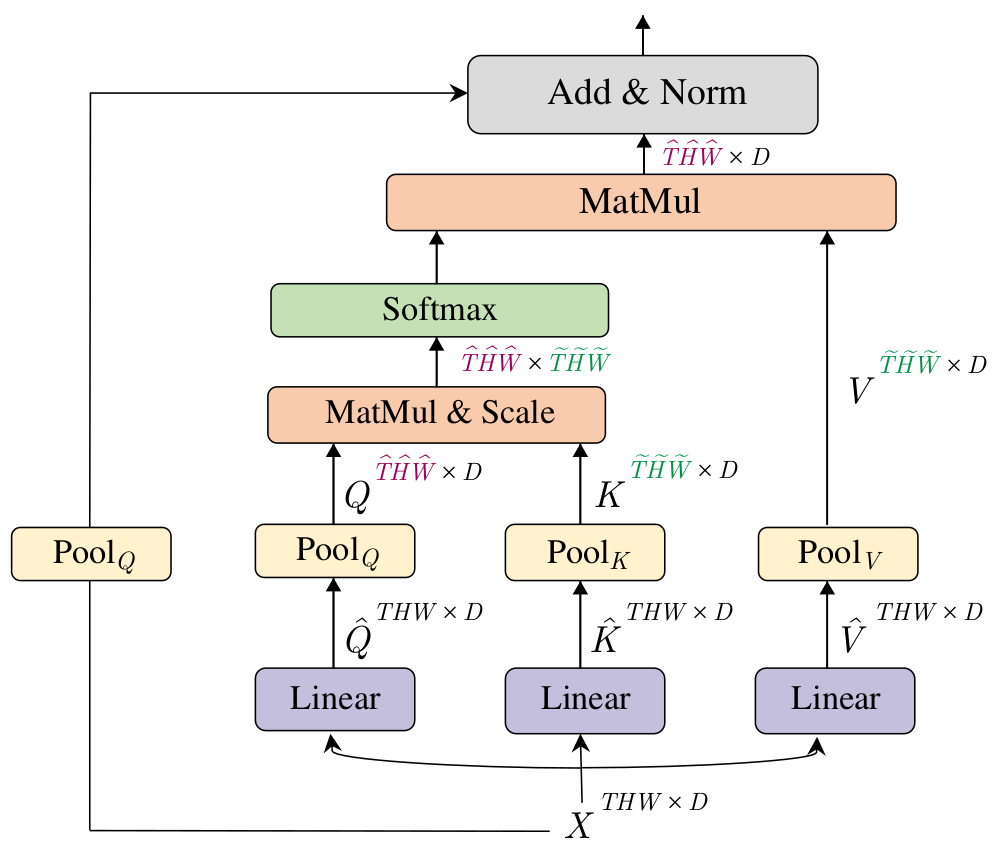

## Configuration

Imports

In [1]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
import ignite.metrics
import ignite.contrib.handlers

Configuration

In [3]:
DATA_DIR='./data'

IMAGE_SIZE = 32
NUM_CLASSES = 10
NUM_WORKERS = 20
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-1
EPOCHS = 100

In [4]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device:", DEVICE)

device: cuda


## Data

In [5]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(IMAGE_SIZE, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])

In [6]:
train_dset = datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=train_transform)
test_dset = datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


In [7]:
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=BATCH_SIZE, shuffle=True,
                                           num_workers=NUM_WORKERS, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dset, batch_size=BATCH_SIZE, shuffle=False,
                                          num_workers=NUM_WORKERS, pin_memory=True)

In [8]:
def dataset_show_image(dset, idx):
    X, Y = dset[idx]
    title = "Ground truth: {}".format(dset.classes[Y])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_axis_off()
    ax.imshow(np.moveaxis(X.numpy(), 0, -1))
    ax.set_title(title)
    plt.show()

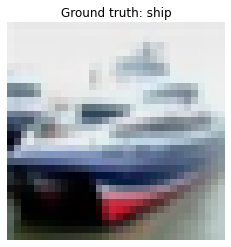

In [9]:
dataset_show_image(test_dset, 1)

## Model

Utilities

In [10]:
def init_linear(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None: nn.init.zeros_(m.bias)

In [11]:
class Residual(nn.Module):
    def __init__(self, *layers, shortcut=None):
        super().__init__()
        self.shortcut = nn.Identity() if shortcut is None else shortcut
        self.residual = nn.Sequential(*layers)
        self.gamma = nn.Parameter(torch.zeros(1))
    
    def forward(self, x):
        return self.shortcut(x) + self.gamma * self.residual(x)

In [12]:
class LayerNormChannels(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.norm = nn.LayerNorm(channels)
    
    def forward(self, x):
        x = x.transpose(1, -1)
        x = self.norm(x)
        x = x.transpose(-1, 1)
        return x

Attention

$$
O = V \mathrm{softmax}\left[\frac{1}{\sqrt{c}}K^{\intercal}Q\right]
$$

In [13]:
class SelfAttention2d(nn.Module):
    def __init__(self, channels, head_channels, heads=1,
                 kernel_q=1, stride_q=1, kernel_kv=1, stride_kv=1, p_drop=0.):
        super().__init__()
        inner_channels = head_channels * heads
        self.heads = heads
        self.head_channels = head_channels
        self.scale = head_channels**-0.5
        self.stride_q = stride_q
        
        padding_q = kernel_q // 2
        padding_kv = kernel_kv // 2
        self.pool_q = nn.MaxPool2d(kernel_q, stride_q, padding_q) if kernel_q > 1 else nn.Identity()
        self.pool_k = nn.MaxPool2d(kernel_kv, stride_kv, padding_kv) if kernel_kv > 1 else nn.Identity()
        self.pool_v = nn.MaxPool2d(kernel_kv, stride_kv, padding_kv) if kernel_kv > 1 else nn.Identity()
        
        self.to_keys = nn.Conv2d(channels, inner_channels, 1)
        self.to_queries = nn.Conv2d(channels, inner_channels, 1)
        self.to_values = nn.Conv2d(channels, inner_channels, 1)
        self.unifyheads = nn.Conv2d(inner_channels, channels, 1)

        self.drop = nn.Dropout(p_drop)
    
    def forward(self, x):
        b, _, h, w = x.shape
        
        keys = self.pool_k(self.to_keys(x)).view(b, self.heads, self.head_channels, -1)
        queries = self.pool_q(self.to_queries(x)).view(b, self.heads, self.head_channels, -1)
        values = self.pool_v(self.to_values(x)).view(b, self.heads, self.head_channels, -1)
        
        att = keys.transpose(-2, -1) @ queries
        att = F.softmax(att * self.scale, dim=-2)
        
        out = values @ att
        out = out.view(b, -1, h // self.stride_q, w //self.stride_q)
        out = self.unifyheads(out)
        out = self.drop(out)
        return out

Transformer

In [14]:
class FeedForward(nn.Sequential):
    def __init__(self, in_channels, out_channels, mult=4, p_drop=0.):
        hidden_channels = in_channels * mult
        super().__init__(
            nn.Conv2d(in_channels, hidden_channels, 1),
            nn.GELU(),
            nn.Conv2d(hidden_channels, out_channels, 1),
            nn.Dropout(p_drop)
        )

In [15]:
class TransformerBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, head_channels, heads=1,
                 kernel_q=1, stride_q=1, kernel_kv=1, stride_kv=1, p_drop=0.):
        
        padding_q = kernel_q // 2
        layers = [Residual(LayerNormChannels(in_channels),
                           SelfAttention2d(in_channels, head_channels, heads,
                                           kernel_q, stride_q, kernel_kv, stride_kv, p_drop),
                           shortcut = nn.MaxPool2d(kernel_q, stride_q, padding_q) if kernel_q > 1
                                                                                  else nn.Identity())]
        
        if in_channels == out_channels:
            layers.append(Residual(LayerNormChannels(in_channels),
                                   FeedForward(in_channels, out_channels, p_drop=p_drop)))
        else:
            layers += [LayerNormChannels(in_channels),
                       Residual(FeedForward(in_channels, out_channels, p_drop=p_drop),
                                shortcut = nn.Conv2d(in_channels, out_channels, 1))]
        super().__init__(*layers)

MViT

In [16]:
class TransformerStack(nn.Sequential):
    def __init__(self, in_channels, head_channels, repetitions, strides, stride_kv, p_drop=0.):
        layers = []
        out_channels = in_channels
        heads = 1
        for rep, stride_q in zip(repetitions, strides):
            kernel_q = stride_q + 1 if stride_q > 1 else 1
            stride_kv = stride_kv // stride_q
            kernel_kv = stride_kv + 1 if stride_kv > 1 else 1
            heads *= stride_q
            for _ in range(rep):
                layers.append(TransformerBlock(in_channels, out_channels, head_channels, heads,
                                               kernel_q, stride_q, kernel_kv, stride_kv, p_drop))
                in_channels = out_channels
                stride_q = 1
                kernel_q = 1
            out_channels *= 2
        super().__init__(*layers)

In [17]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels, out_channels, patch_size, stride, padding):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, patch_size, stride=stride, padding=padding)
    
    def forward(self, x):
        x = self.conv(x)
        return x

In [18]:
class PositionEmbedding(nn.Module):
    def __init__(self, channels, image_size):
        super().__init__()
        self.pos_embedding = nn.Parameter(torch.zeros(1, channels, image_size, image_size))
    
    def forward(self, x):
        x = x + self.pos_embedding
        return x

In [19]:
class Head(nn.Sequential):
    def __init__(self, channels, classes, p_drop=0.):
        super().__init__(
            LayerNormChannels(channels),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(p_drop),
            nn.Linear(channels, classes)
        )

In [20]:
class MViT(nn.Sequential):
    def __init__(self, classes, image_size, repetitions, strides, stride_kv, channels, head_channels,
                 patch_size, patch_stride, patch_padding, in_channels=3, trans_p_drop=0., head_p_drop=0.):
        reduced_size = image_size // patch_stride
        out_channels = channels * 2**(len(repetitions) - 1)
        super().__init__(
            PatchEmbedding(in_channels, channels, patch_size, patch_stride, patch_padding),
            PositionEmbedding(channels, reduced_size),
            TransformerStack(channels, head_channels, repetitions, strides, stride_kv, trans_p_drop),
            Head(out_channels, classes, p_drop=head_p_drop)
        )

In [21]:
model = MViT(NUM_CLASSES, IMAGE_SIZE, repetitions=[2, 2, 2, 2], strides=[1, 2, 2, 2], stride_kv=2,
             channels=64, head_channels=64, patch_size=3, patch_stride=1, patch_padding=1,
             trans_p_drop=0.3, head_p_drop=0.3)

In [22]:
model.apply(init_linear);

In [23]:
model.to(DEVICE);

In [24]:
print("Number of parameters: {:,}".format(sum(p.numel() for p in model.parameters())))

Number of parameters: 6,214,746


## Training

### Optimizer

In [26]:
def separate_parameters(model):
    parameters_decay = set()
    parameters_no_decay = set()
    modules_weight_decay = (nn.Linear, nn.Conv2d)
    modules_no_weight_decay = (nn.LayerNorm, PositionEmbedding)

    for m_name, m in model.named_modules():
        for param_name, param in m.named_parameters():
            full_param_name = f"{m_name}.{param_name}" if m_name else param_name

            if isinstance(m, modules_no_weight_decay):
                parameters_no_decay.add(full_param_name)
            elif param_name.endswith("bias"):
                parameters_no_decay.add(full_param_name)
            elif isinstance(m, Residual) and param_name.endswith("gamma"):
                parameters_no_decay.add(full_param_name)
            elif isinstance(m, modules_weight_decay):
                parameters_decay.add(full_param_name)
    
    # sanity check
    assert len(parameters_decay & parameters_no_decay) == 0
    assert len(parameters_decay) + len(parameters_no_decay) == len(list(model.parameters()))

    return parameters_decay, parameters_no_decay

In [27]:
def get_optimizer(model, learning_rate, weight_decay):
    param_dict = {pn: p for pn, p in model.named_parameters()}
    parameters_decay, parameters_no_decay = separate_parameters(model)
    
    optim_groups = [
        {"params": [param_dict[pn] for pn in parameters_decay], "weight_decay": weight_decay},
        {"params": [param_dict[pn] for pn in parameters_no_decay], "weight_decay": 0.0},
    ]
    optimizer = optim.AdamW(optim_groups, lr=learning_rate)
    return optimizer

### Setup trainer

In [28]:
loss = nn.CrossEntropyLoss()

In [29]:
optimizer = get_optimizer(model, learning_rate=1e-6, weight_decay=WEIGHT_DECAY)

In [30]:
trainer = create_supervised_trainer(model, optimizer, loss, device=DEVICE)

In [31]:
lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE,
                                             steps_per_epoch=len(train_loader), epochs=EPOCHS)

In [32]:
trainer.add_event_handler(Events.ITERATION_COMPLETED, lambda engine: lr_scheduler.step());

In [33]:
ignite.metrics.RunningAverage(output_transform=lambda x: x).attach(trainer, "loss")

In [34]:
val_metrics = {"accuracy": ignite.metrics.Accuracy(), "loss": ignite.metrics.Loss(loss)}

In [35]:
evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=DEVICE)

In [36]:
history = defaultdict(list)

In [37]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    train_state = engine.state
    epoch = train_state.epoch
    max_epochs = train_state.max_epochs
    train_loss = train_state.metrics["loss"]
    history['train loss'].append(train_loss)
    
    evaluator.run(test_loader)
    val_metrics = evaluator.state.metrics
    val_loss = val_metrics["loss"]
    val_acc = val_metrics["accuracy"]
    history['val loss'].append(val_loss)
    history['val acc'].append(val_acc)
    
    print("{}/{} - train: loss {:.3f}; val: loss {:.3f} accuracy {:.3f}".format(
        epoch, max_epochs, train_loss, val_loss, val_acc))

### Start training

In [38]:
trainer.run(train_loader, max_epochs=EPOCHS);

1/100 - train: loss 1.920; val: loss 1.730 accuracy 0.362
2/100 - train: loss 1.559; val: loss 1.601 accuracy 0.431
3/100 - train: loss 1.377; val: loss 1.409 accuracy 0.505
4/100 - train: loss 1.276; val: loss 1.470 accuracy 0.502
5/100 - train: loss 1.199; val: loss 1.291 accuracy 0.540
6/100 - train: loss 1.112; val: loss 1.085 accuracy 0.613
7/100 - train: loss 1.040; val: loss 1.056 accuracy 0.629
8/100 - train: loss 0.986; val: loss 1.032 accuracy 0.641
9/100 - train: loss 0.956; val: loss 0.891 accuracy 0.684
10/100 - train: loss 0.884; val: loss 0.931 accuracy 0.683
11/100 - train: loss 0.872; val: loss 0.840 accuracy 0.714
12/100 - train: loss 0.871; val: loss 0.788 accuracy 0.720
13/100 - train: loss 0.803; val: loss 0.755 accuracy 0.739
14/100 - train: loss 0.798; val: loss 0.742 accuracy 0.746
15/100 - train: loss 0.798; val: loss 0.695 accuracy 0.765
16/100 - train: loss 0.752; val: loss 0.769 accuracy 0.734
17/100 - train: loss 0.740; val: loss 0.832 accuracy 0.733
18/100

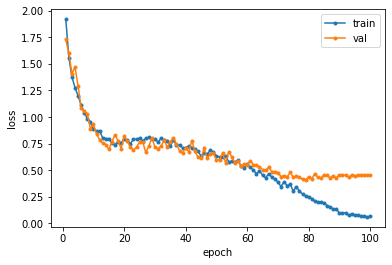

In [39]:
fig = plt.figure()
ax = fig.add_subplot(111)
xs = np.arange(1, len(history['train loss']) + 1)
ax.plot(xs, history['train loss'], '.-', label='train')
ax.plot(xs, history['val loss'], '.-', label='val')
ax.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
plt.show()

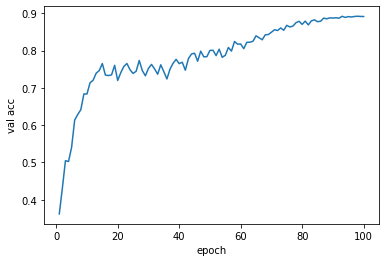

In [40]:
fig = plt.figure()
ax = fig.add_subplot(111)
xs = np.arange(1, len(history['val acc']) + 1)
ax.plot(xs, history['val acc'], '-')
ax.set_xlabel('epoch')
ax.set_ylabel('val acc')
plt.show()